In [474]:
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt
from time import sleep

In [475]:
#Base de otimização de rotas

otimizacao_rotas = pd.read_excel("Otimização de rotas.xlsx",sheet_name='Trajeto Geral (Equ x Base Faz)', skiprows=6).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

In [476]:
#Capacidade por equipe
capacidade_equipe = pd.read_excel("cadastro equipes e demandas.xlsx", sheet_name='Capacidade por equipe')

In [477]:
#Base de demandas

demanda = pd.read_excel('cadastro equipes e demandas.xlsx', sheet_name='Demanda por fazenda', dtype={'ID Fazenda': 'object', 'Mês de Demanda': 'datetime64[ns]'})

In [478]:
#Função de máscara

def mascara(df, coluna,n_digitos):
    df[coluna] = df[coluna].astype(str)
    df[coluna] = str("000") + df[coluna]
    df[coluna] = df[coluna].astype(str).str[-n_digitos:] 
    return df

In [479]:
#demanda 
demanda = mascara(demanda,'ID Fazenda', 4)

demanda.sample(3)#tail(3)#.head(5)

,ID Fazenda,Fazenda,Área Avaliada,Mês avaliação,Data de Avaliação
752,2159,SANTA THEREZA VII - ANGATUBA,167.22,2024-03-01,2024-03-14
95,0129,ESTIVA III,231.33,2024-04-01,2024-04-04
556,0624,SÃO GERALDO II - BORACÉIA,16.20,2024-04-01,2024-04-16


In [480]:
#Data frame de equipes e siglas
equipes = [ i for  i in otimizacao_rotas['COD'].str[7:].unique()]
equipes_s = [ i for  i in otimizacao_rotas['Equipe'].unique()]


equipes_base = pd.DataFrame(
    { 'Equipe': equipes,
     'Equipe sigla' : equipes_s
    }
)

equipes_base.head(len(equipes))

,Equipe,Equipe sigla
0,Lençóis Paulista,A
1,Duartina,B
2,Garça,C
3,Pirajuí,D
4,Bauru,E
5,Getulina,G
6,Cabrália Paulista,H


In [481]:
#Capacidade da equipe 

capacidade_equipe['Gordura'] = 0.05

capacidade_equipe['Capacidade ajustada'] = (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade']) + capacidade_equipe['Capacidade']

#capacidade_equipe['Capacidade minima'] = capacidade_equipe['Capacidade'] - (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade'])


capacidade_equipe = capacidade_equipe.merge(equipes_base, on='Equipe', how='left')

capacidade_equipe.head(6)

,Equipe,Capacidade,Distancia,Mês Operacional,Gordura,Capacidade ajustada,Equipe sigla
0,Lençóis Paulista,7400,5000,2024-04-01,0.05,7770.0,A
1,Duartina,7400,5000,2024-04-01,0.05,7770.0,B
2,Garça,7400,5000,2024-04-01,0.05,7770.0,C
3,Pirajuí,7400,5000,2024-04-01,0.05,7770.0,D
4,Bauru,7400,5000,2024-04-01,0.05,7770.0,E
5,Getulina,7400,5000,2024-04-01,0.05,7770.0,G


In [482]:
#Otimização de rotas

otimizacao_rotas = mascara(otimizacao_rotas,'ID Fazenda',4)

otimizacao_rotas

,Equipe,Cidade origem,ID Fazenda,Projeto,Área,COD,Trajeto (Km)
0,A,Lençóis Paulista,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001
1,B,Duartina,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400
2,C,Garça,0001,MAMEDINA,1772.63,0001 - Garça,110.671138
3,D,Pirajuí,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666
4,E,Bauru,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475
...,...,...,...,...,...,...,...
6617,C,Garça,2417,CAFEZAL,120.82,2417 - Garça,252.471501
6618,D,Pirajuí,2417,CAFEZAL,120.82,2417 - Pirajuí,262.590625
6619,E,Bauru,2417,CAFEZAL,120.82,2417 - Bauru,207.695434
6620,G,Getulina,2417,CAFEZAL,120.82,2417 - Getulina,312.662195


In [483]:
#Construindo otimização de rotas

#trazendo base de demandas
otimizacao_rotas = otimizacao_rotas.merge(demanda[['ID Fazenda','Área Avaliada', 'Mês avaliação']], left_on='ID Fazenda', right_on='ID Fazenda', how='left')

#Ordenando a base
otimizacao_rotas = otimizacao_rotas.sort_values(['Mês avaliação','ID Fazenda','Trajeto (Km)'],ascending=[True,True,True])

#Capacidade por equipe
otimizacao_rotas = otimizacao_rotas.merge(capacidade_equipe[['Mês Operacional', 'Capacidade', 'Capacidade ajustada', 'Equipe sigla']],left_on=['Equipe','Mês avaliação'], right_on=['Equipe sigla','Mês Operacional'], how='left')

otimizacao_rotas= otimizacao_rotas.rename({
    'Mês Operacional':'Mês operacional equipe',
    'Mês avaliação': 'Mês demanda'
}, axis=1)


otimizacao_rotas = otimizacao_rotas.drop(['Equipe sigla','Cidade origem'],axis=1)


otimizacao_rotas = otimizacao_rotas[pd.notna(otimizacao_rotas['Mês operacional equipe'])]


In [484]:
#Resetando o índice para utilizá-lo no i.loc
otimizacao_rotas.reset_index(drop=True, inplace=True)

otimizacao_rotas['Equipe mais próxima'] = 0
ordem = 0

for i in range(1, len(otimizacao_rotas)):
    if otimizacao_rotas.loc[i, 'ID Fazenda'] == otimizacao_rotas.loc[i-1, 'ID Fazenda']:
        ordem += 1
    else:
        ordem = 0
    otimizacao_rotas.loc[i, 'Equipe mais próxima'] = ordem

In [485]:
#Criar um print para ir rodando quais são as equipes mais próximas e qual a distância. Pode ser um dicionário. mas deve ser printado para mostrar a funcionalidade da ferramenta

In [486]:
#Criar uma lógica para criar um dicionário que vai aumentando a demanda conforme é atribuído fazendas para ela de acordo com a coluna equipe mais próxima

#A fazenda deve sempre ser atribuída no momento que ela for mais próxima da equipe, a capacidade só pode ser olhada quando a equipe mais próxima for maior que zero

#Tabelinha de demanda da equipe com a demanda mês atual dela


In [487]:
#Analisar capacidade

demanda_total_mes = demanda.groupby(['Mês avaliação'])['Área Avaliada'].sum().reset_index()

capacidade_total_mes = capacidade_equipe.groupby(['Mês Operacional'])['Capacidade ajustada'].sum().reset_index()

analise_capacidade = demanda_total_mes.merge(capacidade_total_mes, left_on='Mês avaliação', right_on='Mês Operacional', how='left')

analise_capacidade['delta capacidade'] = analise_capacidade['Capacidade ajustada'] - analise_capacidade['Área Avaliada']   

analise_capacidade['status capacidade'] = np.where(analise_capacidade['delta capacidade'] > 0 , 'temos Capacidade para a demanda', 'não temos capacidade para a demanda')

analise_capacidade['Mês avaliação'] = analise_capacidade['Mês avaliação'].dt.strftime('%m-%y')

for k,v in analise_capacidade.iterrows():
    print(f"No mês {v['Mês avaliação']} {v['status capacidade']}")


analise_capacidade


No mês 03-24 não temos capacidade para a demanda
No mês 04-24 não temos capacidade para a demanda


,Mês avaliação,Área Avaliada,Mês Operacional,Capacidade ajustada,delta capacidade,status capacidade
0,03-24,85794.63,2024-03-01,54390.0,-31404.63,não temos capacidade para a demanda
1,04-24,71352.96,2024-04-01,54390.0,-16962.96,não temos capacidade para a demanda


In [488]:
#Plano A

#Sempre vai me trazer qual é a equipe mais próxima

def definir_equipe(row,proximidade):
    if (row['Equipe mais próxima'] == proximidade ) & (row['Mês demanda'] == row['Mês operacional equipe']):
        return row['Equipe']
    else:
        return np.nan

otimizacao_rotas['Plano A'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(0,))

otimizacao_rotas['Plano B'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(1,))

otimizacao_rotas['Plano C'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(2,))


#O ffill preenche todas as linhas até embaixo, fazendo com que todas as linhas da mesma fazenda sejam preenchidas até então


In [489]:
#Agora com o plano A definido, vamos criar uma base para ir somando a demanda da equipe por programação

#Limitador de quilometragem 

#A Equipe pode andar quantos quilometros por mês? 
#Do mesmo jeito que tenho capacidade máxima, devo ter distância máxima para percorrer



carteira_equipe = {}


def adiciona_equipe(informacoes_equipe, dicionario, demanda_inicial, km_inicial):
    for _, v in informacoes_equipe.iterrows():
        dicionario[v['Equipe sigla'] + v['Mês Operacional'].strftime('%m-%y')] = {
            'equipe': v['Equipe sigla'],
            'mes': pd.to_datetime(v['Mês Operacional']),
            'demanda': demanda_inicial,
            'capacidade maxima': v['Capacidade ajustada'],
            'distancia maxima' : v['Distancia'],#
            #'capacidade minima': v['Capacidade minima']
            'km': km_inicial
        }

# Adicionar equipes ao dicionário
adiciona_equipe(capacidade_equipe, carteira_equipe, 0,0)


In [490]:
carteira_df = pd.DataFrame.from_dict(carteira_equipe,orient='index')



In [491]:
#Construir função para ir aumentando a carteira de áreas da equipe


def credito_demanda(carteira_df,banco_areas):

    banco_areas['equipe atribuída'] = ''
    banco_areas['equipe atribuída att'] = ''


    for chave_banco, valor_banco in banco_areas.iterrows():

    
        for chave_carteira, valor_carteira in carteira_df.items():

            #Ao invez de definir o plano A, posso utilizar o idxmin() e pegar o mínimo para o plano, e caso a equipe não tenha mais capacidade pode ser que ele não entre na demanda
                #Tentar evoluir na ideia, pode ser a solução para os problemas futuros
           
            if (valor_carteira['equipe'] == valor_banco['Plano A']) & (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):
      
                
            #Define a equipe para a equipe mais próxima que é o Plano A
                if  ((valor_banco['Área Avaliada'] + valor_carteira['demanda']) < valor_carteira['capacidade maxima']) & \
                ((valor_banco['Trajeto (Km)'] + valor_carteira['km']) < valor_carteira['distancia maxima']):
                    
                    #Atribuir a fazenda para a equipe
                    banco_areas.loc[chave_banco,'equipe atribuída'] = valor_carteira['equipe']
                   
                   #Somar demandas de área e km
                    valor_carteira['demanda'] += valor_banco['Área Avaliada']
                    valor_carteira['km'] += valor_banco['Trajeto (Km)']

                    print(f"demanda adicionada de {valor_banco['Área Avaliada']:.2f} para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda adicionada é {valor_banco['ID Fazenda']}")
            
               
            #Definir a equipe para o plano B no momento em que a soma da área avaliada mais a demanda é menor que a capacidade máxima da carteira
                else:

                    #Definindo quais são as fazendas que não temos capacidade para as equipes 
                    banco_areas.loc[chave_banco,'equipe atribuída'] = 'Sem capacidade'
                    banco_areas['equipe atribuída att'] = banco_areas.groupby('ID Fazenda')['equipe atribuída'].transform('first')

                    print(f"Fazenda não adicionada, falta capacidade para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda não adicionada é {valor_banco['ID Fazenda']}")


        
    #Tratar as áreas que não temos capacidade de atuar, e que precisam rodar no plano B
    for chave_banco, valor_banco in banco_areas.iterrows():
                        
        for chave_carteira, valor_carteira in carteira_df.items():    

            if  (valor_carteira['equipe'] == valor_banco['Plano B']) & (valor_banco['equipe atribuída att'] == 'Sem capacidade') & \
                (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):
                
                if (((valor_banco['Área Avaliada'] + valor_carteira['demanda'])) < valor_carteira['capacidade maxima']) & \
                ((valor_banco['Trajeto (Km)'] + valor_carteira['km']) < valor_carteira['distancia maxima']):
                    
                    banco_areas.loc[chave_banco,'equipe atribuída'] = valor_carteira['equipe']
                    
                    valor_carteira['demanda'] += valor_banco['Área Avaliada']
                    valor_carteira['km'] += valor_banco['Trajeto (Km)']





                print('iterando novamente na base para os talhões sem capacidade')

            #Define tudo o que é plano B

            else:
                print('Não necessário iterar')

    return banco_areas

                   

                    
                                       

                                


                    
                #sleep(1)

        #banco_areas['equipe atribuída'] = banco_areas['equipe atribuída'].replace('', None).ffill()
            

In [492]:
#Atribuir a fazenda já programada para a base de dados para classificar qual pode ser o plano B ou os subsequentes

#Próximo passo, criar um identificador de que a fazenda já foi adicionada

#Criar um loop para ver novamente se é possível adicionar algo além do que já foi adicionado, caso a equipe ainda tenha capacidade

#Um loop para as fazendas do próximo mês anteciparem o mês seguinte, nunca o anterior.

#Encontrar uma forma de dizer ao usuário que a capacidade desejada não atende a demanda das equipes.

#Após rodar o código, mostrar quais são as fazendas que não possuem capacidade

#Definir o plano B para a demanda

#Definir o plano C para a demanda 


#Encontra quais são as duas equipes mais próximas para atribuir a fazenda para elas, sempre trazendo que está mais próximo no momento



In [493]:
credito_demanda(carteira_equipe,otimizacao_rotas)

demanda adicionada de 748.94 para a equipe H
fazenda adicionada é 0003
demanda adicionada de 820.61 para a equipe D
fazenda adicionada é 0006
demanda adicionada de 404.91 para a equipe A
fazenda adicionada é 0010
demanda adicionada de 12.36 para a equipe A
fazenda adicionada é 0016
demanda adicionada de 144.01 para a equipe D
fazenda adicionada é 0024
demanda adicionada de 168.63 para a equipe B
fazenda adicionada é 0029
demanda adicionada de 373.19 para a equipe E
fazenda adicionada é 0030
demanda adicionada de 864.02 para a equipe A
fazenda adicionada é 0035
demanda adicionada de 141.83 para a equipe A
fazenda adicionada é 0048
demanda adicionada de 62.21 para a equipe A
fazenda adicionada é 0049
demanda adicionada de 692.38 para a equipe E
fazenda adicionada é 0057
demanda adicionada de 71.38 para a equipe E
fazenda adicionada é 0058
demanda adicionada de 55.12 para a equipe B
fazenda adicionada é 0061
demanda adicionada de 112.64 para a equipe E
fazenda adicionada é 0074
demanda ad

,Equipe,ID Fazenda,Projeto,Área,COD,Trajeto (Km),Área Avaliada,Mês demanda,Mês operacional equipe,Capacidade,Capacidade ajustada,Equipe mais próxima,Plano A,Plano B,Plano C,equipe atribuída,equipe atribuída att
0,H,0003,UNIÃO,913.96,0003 - Cabrália Paulista,18.858908,748.94,2024-03-01,2024-03-01,7400.0,7770.0,0,H,NaN,NaN,H,H
1,B,0003,UNIÃO,913.96,0003 - Duartina,29.064904,748.94,2024-03-01,2024-03-01,7400.0,7770.0,1,NaN,B,NaN,,H
2,E,0003,UNIÃO,913.96,0003 - Bauru,40.215705,748.94,2024-03-01,2024-03-01,7400.0,7770.0,2,NaN,NaN,E,,H
3,A,0003,UNIÃO,913.96,0003 - Lençóis Paulista,64.514186,748.94,2024-03-01,2024-03-01,7400.0,7770.0,3,NaN,NaN,NaN,,H
4,C,0003,UNIÃO,913.96,0003 - Garça,73.350765,748.94,2024-03-01,2024-03-01,7400.0,7770.0,4,NaN,NaN,NaN,,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5602,B,2411,PINDORAMA II - GLEBA C,860.08,2411 - Duartina,81.725020,18.66,2024-04-01,2024-04-01,7400.0,7770.0,2,NaN,NaN,B,,Sem capacidade
5603,A,2411,PINDORAMA II - GLEBA C,860.08,2411 - Lençóis Paulista,82.414277,18.66,2024-04-01,2024-04-01,7400.0,7770.0,3,NaN,NaN,NaN,,Sem capacidade
5604,H,2411,PINDORAMA II - GLEBA C,860.08,2411 - Cabrália Paulista,85.177795,18.66,2024-04-01,2024-04-01,7400.0,7770.0,4,NaN,NaN,NaN,,Sem capacidade
5605,C,2411,PINDORAMA II - GLEBA C,860.08,2411 - Garça,97.382755,18.66,2024-04-01,2024-04-01,7400.0,7770.0,5,NaN,NaN,NaN,,Sem capacidade


In [494]:
otimizacao_rotas.to_excel('atribuição de equipes.xlsx')

In [495]:
#Data frame do dicionário e seguindo a orientação por index

carteira_df = pd.DataFrame.from_dict(carteira_equipe, orient='index')

carteira_df

,equipe,mes,demanda,capacidade maxima,distancia maxima,km
A04-24,A,2024-04-01,7756.27,7770.0,5000,1710.170594
B04-24,B,2024-04-01,7769.28,7770.0,5000,930.883547
C04-24,C,2024-04-01,7768.44,7770.0,5000,1162.613434
D04-24,D,2024-04-01,7755.56,7770.0,5000,1068.898359
E04-24,E,2024-04-01,7767.10,7770.0,5000,1154.550697
G04-24,G,2024-04-01,7616.09,7770.0,5000,1990.795393
H04-24,H,2024-04-01,7752.35,7770.0,5000,1345.186637
A03-24,A,2024-03-01,7767.02,7770.0,5000,4462.710665
B03-24,B,2024-03-01,7594.46,7770.0,5000,1574.292653
C03-24,C,2024-03-01,7726.71,7770.0,5000,1252.377074


In [496]:
#filtro_data = pd.Timestamp('2024-04-01')

#distribuicao = otimizacao_rotas[(otimizacao_rotas['Equipe mais próxima'] == 0 ) & (otimizacao_rotas['Mês operacional equipe'] == filtro_data) ].groupby('Equipe')['Área Avaliada'].sum().reset_index()


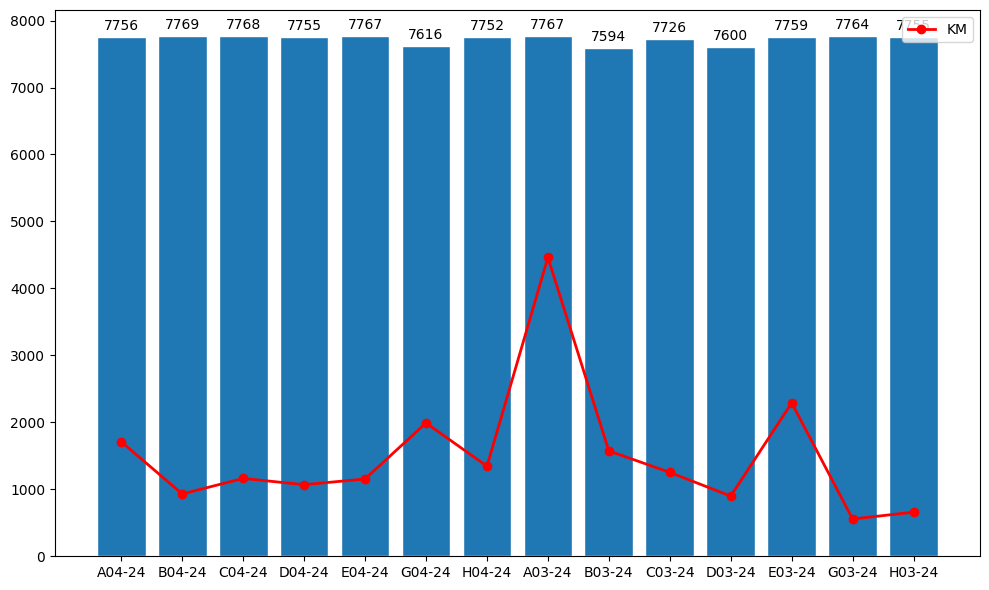

In [497]:
fig, ax = plt.subplots(figsize=(10, 6))  # Largura de 10 polegadas e altura de 6 polegadas

# Dados do gráfico de barras
xbar = carteira_df.index
ybar = carteira_df['demanda']

# Dados do gráfico de linhas
xline = carteira_df.index
yline = carteira_df['km']

# Criar o gráfico de barras
bars = ax.bar(xbar, ybar, width=0.8, edgecolor='white')

# Adicionar rótulos às barras
ax.bar_label(bars, fmt='%d', padding=3)

# Criar o gráfico de linhas no mesmo conjunto de eixos
ax.plot(xline, yline, color='red', marker='o', linestyle='-', linewidth=2, label='KM')

ax.legend()

fig.tight_layout()

plt.show()


In [501]:
equipes_base

,Equipe,Equipe sigla
0,Lençóis Paulista,A
1,Duartina,B
2,Garça,C
3,Pirajuí,D
4,Bauru,E
5,Getulina,G
6,Cabrália Paulista,H
